In [1]:
clear all

In [2]:
!pip install polars

  Using cached polars-1.3.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
Using cached polars-1.3.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)


In [3]:
!pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)


In [4]:
!pip install pytorchtools

  Using cached pytorchtools-0.0.2-py2.py3-none-any.whl.metadata (2.2 kB)
Using cached pytorchtools-0.0.2-py2.py3-none-any.whl (3.1 kB)


In [5]:
import polars as pl
import cv2
import glob
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn import Module
# from torchsummary import summary
from torchvision import models, io
import torch.nn.functional as F
from datetime import datetime
import os
from tqdm import tqdm
# import zipfile
# import shutil
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity

In [5]:
# Go requesting all of my pictures

In [40]:
os.getcwd()

'/home/jovyan/my_work/Egypto'

In [15]:
#  with zipfile.ZipFile("/home/jovyan/my_work/Egypto/dfs.zip") as zip_ref:
#      zip_ref.extractall("/home/jovyan/my_work/Egypto/dfs")

In [12]:
# source_pattern = "/home/jovyan/my_work/Egypto/CP*/cropped_pictures/*"
# destination_dir = "/home/jovyan/my_work/Egypto/Images"

# # Make sure the destination directory exists
# os.makedirs(destination_dir, exist_ok=True)

# # Iterate over all files in the source pattern
# for file_path in glob.glob(source_pattern):
#     if os.path.isfile(file_path):  # Ensure it's a file
#         shutil.move(file_path, destination_dir)

# # Check the number of files in the destination directory
# num_files = len(os.listdir(destination_dir))
# print(f"Number of files moved: {num_files}")

Number of files moved: 68497


In [6]:
dfs=[pl.read_csv(filename) for filename in glob.glob('/home/jovyan/my_work/Egypto/dfs/dfs/df_*.csv')]
df=pl.concat(dfs)
df.head()

filenames,classes,bb
str,str,str
"""drive/MyDrive/cropped_pictures…","""""",""""""
"""drive/MyDrive/cropped_pictures…","""2""","""72.0,37.0,236.23839330673218,1…"
"""drive/MyDrive/cropped_pictures…","""""",""""""
"""drive/MyDrive/cropped_pictures…","""0""","""0.0,0.0,225.8830212788887,409.…"
"""drive/MyDrive/cropped_pictures…","""""",""""""


In [7]:
df=df.with_columns(pl.col('filenames').str.split('/').list.last())
df.head()

filenames,classes,bb
str,str,str
"""425942001_300_300_243_543_empt…","""""",""""""
"""425942001_300_300_243_543_cara…","""2""","""72.0,37.0,236.23839330673218,1…"
"""420886001_300_300_1028_1328_em…","""""",""""""
"""420886001_300_300_1028_1328_ca…","""0""","""0.0,0.0,225.8830212788887,409.…"
"""423879001_300_300_814_1114_emp…","""""",""""""


In [8]:
all_images=os.listdir('/home/jovyan/my_work/Egypto/Images')
existing_files_series = pl.Series(all_images)


In [9]:
df=df.with_columns(pl.col('filenames').is_in(all_images).alias('new_image')).filter(pl.col('new_image'))

In [10]:
df=df.drop('new_image')
df.head()

filenames,classes,bb
str,str,str
"""425942001_300_300_243_543_empt…","""""",""""""
"""425942001_300_300_243_543_cara…","""2""","""72.0,37.0,236.23839330673218,1…"
"""420886001_300_300_1028_1328_em…","""""",""""""
"""420886001_300_300_1028_1328_ca…","""0""","""0.0,0.0,225.8830212788887,409.…"
"""423879001_300_300_814_1114_emp…","""""",""""""


In [11]:
df=df.with_columns(pl.col('filenames').str.split('_').list.last().str.split('.').list.first().alias('empty')).filter(pl.col('empty')=='caractere').drop('empty')

We're checkin for duplicates

In [69]:
df['filenames'][1]

'432546001_1200_300_1001_1301_caractere.png'

In [ ]:
df['filenames'].value_counts(

).filter(pl.col('count')>1
         ).with_columns(pl.col('filenames').str.split('_').list.last().str.split('.').list.first().alias('caractere_or_empty')
         ).filter(pl.col('caractere_or_empty')=='caractere').shape

(103, 3)

droping the duplicates and keeping the last one ( since the photos were probably overwritten because they were assigned the same same )

In [12]:
df=df.unique(subset='filenames', keep='last')

In [43]:
df=df[1:,:]

In [14]:
df.shape

(34241, 3)

## Customization du dataset [link here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [ ]:
df['bb'][0]

''

In [13]:
class CustomDataset(Dataset):
  """
  This Class creates tensor for each value in a dataframe.
  """
  def __init__(self, df, transform:bool):
    """
      df: dataframe with the annotations
    root_dir: directory with all the images
    transform: Optionnal transform to apply
    """

    self.df=df
    self.transform=transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    # On rajoute le transform, voir ce que ça fait sur les résultats
    img_name=self.df['filenames'][idx]
    image_file=os.path.join('/home/jovyan/my_work/Egypto/Images',img_name)
    image=cv2.imread(image_file)
    image=1.6*image - 50
    image=image/255

    # if image is None:
    #   raise FileNotFoundError(f"Image {img_name} not found")
    if self.transform:
      image=self.transform(image)
      #On verrifie que 'bb' et 'classes' sont non vides sinon ca risque de buguer
    if image is not None:
      image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)
    bb_str=self.df['bb'][idx]
    if bb_str:
      bb=list(map(float,self.df['bb'][idx].split(',')))
      target=torch.tensor(bb,dtype=torch.float32)
#     else:
#       target=torch.tensor([0,0,300,300])
    classe_str=self.df['classes'][idx]
    if classe_str:
        label_map = {'0': 0, '1': 1, '2': 2}
        label = torch.tensor(label_map.get(classe_str, -1), dtype=torch.float32)
#     else:
#       label = torch.tensor(3, dtype=torch.float32)

    return image, target, label


In [14]:
def custom_collate_fn(batch):
  """
  This function collates the tensor for them to have the same size

  batch: batch in the dataloader
  """
  images, targets, labels = zip(*batch)

    # Convert images from numpy arrays to torch tensors if needed
  images = [torch.tensor(image) if isinstance(image, np.ndarray) else image for image in images]
  images = torch.stack(images, 0)
  bbox= [torch.tensor(t) if isinstance(t, np.ndarray) else t for t in targets]
  bbox_stacked=torch.stack(bbox,0)
  cls= [torch.tensor(c) if isinstance(c, np.ndarray) else c for c in labels]
  cls_stacked=torch.stack(cls,0)

  return images, bbox_stacked, labels

In [15]:
train, test= train_test_split(df, test_size=0.3, random_state=42, shuffle=True, stratify=df['classes'])

In [16]:
dataset_train=CustomDataset(train, transform=False )
dataset_test=CustomDataset(test, transform=False)
dataloader_train=DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=custom_collate_fn, num_workers=4)
dataloader_test=DataLoader(dataset_test, batch_size=32, shuffle=True, collate_fn=custom_collate_fn, num_workers=4)

In [17]:
class VGG16(nn.Module):
  def __init__(self, num_classes=3, num_bbox_coords=4):
    super(VGG16, self).__init__()
    self.layer1= nn.Sequential(nn.Conv2d(3,64, (3,3)),
                               nn.BatchNorm2d(64),
                               nn.ReLU())
    self.layer2=nn.Sequential(nn.Conv2d(64,64, (3,3)),
                              nn.BatchNorm2d(64),
                              nn.ReLU(),
                              nn.MaxPool2d((2,2), stride=2))
    self.layer3= nn.Sequential(nn.Conv2d(64,128, (3,3)),
                               nn.BatchNorm2d(128),
                               nn.ReLU())
    self.layer4= nn.Sequential(nn.Conv2d(128,128,(3,3)),
                               nn.BatchNorm2d(128),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2), stride=2))
    self.layer5= nn.Sequential(nn.Conv2d(128,256,(3,3)),
                               nn.BatchNorm2d(256),
                               nn.ReLU())
    self.layer6=nn.Sequential(nn.Conv2d(256,256, (3,3)),
                              nn.BatchNorm2d(256),
                              nn.ReLU())
    self.layer7=nn.Sequential(nn.Conv2d(256,256, (3,3)),
                              nn.BatchNorm2d(256),
                              nn.ReLU(),
                              nn.MaxPool2d((2,2), stride=2, ceil_mode=True))
    self.layer8=nn.Sequential(nn.Conv2d(256,512, (3,3)),
                              nn.BatchNorm2d(512),
                              nn.ReLU())
    self.layer9=nn.Sequential(nn.Conv2d(512,512, (3,3)),
                              nn.BatchNorm2d(512),
                              nn.ReLU(),
                             nn.MaxPool2d((2,2),stride=2))
    self.layer10=nn.Sequential(nn.Conv2d(512,512, (3,3)),
                              nn.BatchNorm2d(512),
                              nn.ReLU(),
                               nn.MaxPool2d((2,2), stride=2))
#     self.layer11=nn.Sequential(nn.Conv2d(512,512, (3,3)),
#                               nn.BatchNorm2d(512),
#                               nn.ReLU())
#     self.layer12=nn.Sequential(nn.Conv2d(512,512, (3,3)),
#                               nn.BatchNorm2d(512),
#                               nn.ReLU())
#     self.layer13=nn.Sequential(nn.Conv2d(512,512, (3,3)),
#                               nn.BatchNorm2d(512),
#                               nn.ReLU(),
#                                nn.MaxPool2d((2,2), stride=2))
    self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc=nn.Sequential(nn.Dropout(0.6),
                          nn.Linear(512, 4096),
                          nn.ReLU())
    self.fc1=nn.Sequential(nn.Dropout(0.6),
                           nn.Linear(4096, 4096),
                           nn.ReLU())
    self.fc_bbox=nn.Linear(4096,num_bbox_coords)
    self.fc_class=nn.Linear(4096, num_classes)



  def forward(self,x):
    out=self.layer1(x)
    out=self.layer2(out)
    out=self.layer3(out)
    out=self.layer4(out)
    out=self.layer5(out)
    out=self.layer6(out)
    out=self.layer7(out)
    out=self.layer8(out)
    out=self.layer9(out)
    out=self.layer10(out)
#     out=self.layer11(out)
#     out=self.layer12(out)
#     out=self.layer13(out)
    out=self.global_avg_pool(out)
    out=out.view(out.size(0), -1)
    out=self.fc(out)
    out=self.fc1(out)
    out_bbox=self.fc_bbox(out)
    out_class=self.fc_class(out)
#     probabilities_class=F.softmax(out_class, dim=1)
#     predictions = torch.argmax(probabilities_class, dim=1)
#     predictions = torch.clamp(predictions, min=0, max=3)
    return out_bbox, out_class

labels=['class0', 'class1', 'class2']
module=VGG16(num_classes=len(labels)).to('cuda')
#summary(module, input_size=(3,300,300))

In [18]:
class EarlyStopping:
    def __init__(self,patience=3, verbose=False, delta=0):
        self.patience=patience
        self.verbose=verbose
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf
        self.delta=delta
    
    def __call__(self,val_loss,model):
        score=-val_loss
        if self.best_score is None:
            self.best_score=score
        elif score<self.best_score + self.delta:
            self.counter+=1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter>=self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0
            

# On prend la même loss et le même optimizer qu'ici

In [19]:
loss_fn=torch.nn.CrossEntropyLoss()

In [20]:
#optimizer=optim.SGD(module.parameters(), lr=0.01, momentum=0.5)
optimizer=torch.optim.Adam(module.parameters(),lr=0.001, weight_decay=1e-4)
#scheduler=lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [21]:
import torch.nn.functional as F

def custom_loss_fn(bbox_outputs, class_outputs, bbox_targets, class_number):
    bbox_targets = torch.stack([b for b in bbox_targets])
    if class_outputs.dtype != torch.float:
      class_outputs = class_outputs.float()
    #print('classes_outputs', class_outputs.dtype, class_number.dtype)

    #print("before l1 loss")
    bbox_loss = F.smooth_l1_loss(bbox_outputs, bbox_targets, reduction='mean')
    class_loss = loss_fn(class_outputs, class_number)
    #Faisons une moyenne des deux losses et predre que label pour images vides
    #Rescaler les loss
    total_loss = bbox_loss + class_loss
    return total_loss, bbox_loss, class_loss


In [29]:
def train_one_epoch(epoch_index, tb_writer,total_correct, total_samples):
    running_loss = 0
    last_loss = 0

    for i, (image, bbox, classe) in enumerate(dataloader_train):
        # Décomposition des données
        inputs=image.to("cuda")
        #Corriger liste de tensors
        bbox_targets = [b.to("cuda") for b in bbox]
        #Classe_target doit être un torch.long pour crossentropy
        classe=np.asarray(classe)
        class_targets=torch.tensor(classe,dtype=torch.int64).to("cuda")
        
        bbox_outputs, class_outputs = module(inputs)
        _,predictions=torch.max(class_outputs,1)
        total_correct+=(predictions==class_targets).sum().item()
        total_samples+=class_targets.size(0)
        loss, bbox_loss, class_loss = custom_loss_fn(bbox_outputs, class_outputs, bbox_targets, class_targets)
        optimizer.zero_grad()
        loss.backward()
        #gradient clippig to evoid gradients becoming too large during backpropagation
        #torch.nn.utils.clip_grad_norm_(module.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        #print(f"everything works")
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print('batch {} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(dataloader_train) + i + 1
            #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
            accuracy=100*total_correct/total_samples
            #On peut essayer de mesurer la distance entre ce qui est prédit et la vraie bounding box
            distance=bbox_targets[-1]-bbox_outputs[-1]
            print('distance:',distance)
            print('batch{} acc: {}'.format(i+1, accuracy))
            print(bbox_loss, class_loss)
    #scheduler.step()
    return last_loss


In [30]:
early_stopping=EarlyStopping()
timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')
log_file='log_trains_1'
#os.makedirs(log_file)
writer=SummaryWriter(log_file.format(timestamp))
epoch_number=0
EPOCHS=30
best_v_loss=1
for epoch in tqdm(range(EPOCHS)):
  total_correct=0
  total_samples=0
  total_v_correct=0
  total_v_samples=0    
  print('EPOCH{}'.format(epoch_number + 1))
  module.train(True)
  #print(f"model is Trained")
  # try:
  torch.cuda.empty_cache()
  avg_loss=train_one_epoch(epoch_number,writer, total_correct, total_samples)
  torch.cuda.empty_cache()
  #print(f"everything works for avg_loss")

  running_vloss=0
  module.eval()
  #print(f"model is evaluated")
  with torch.no_grad():
      
    for i,(vimages, vbbox, vclass) in enumerate(dataloader_test):
      vinputs= vimages.to("cuda")
      vbbox_target=[b.to("cuda") for b in vbbox]
      vclass_targets=np.asarray(vclass)
      vclass_target=torch.tensor(vclass_targets, dtype=torch.int64).to("cuda")
      voutputs_bbox, voutputs_class=module(vinputs)
      _,v_predictions=torch.max(voutputs_class,1)
      total_v_correct+=(v_predictions==vclass_target).sum().item()
      total_v_samples+=vclass_target.size(0)
      vloss, vbbox_loss, vclasse_loss =custom_loss_fn(voutputs_bbox, voutputs_class, vbbox_target, vclass_target)
      running_vloss+=vloss
 
  v_accuracy=100*total_v_correct/total_v_samples
  print(f'validation acc: {v_accuracy}')
  avg_vloss=running_vloss/(i+1)
  print('LOSS train {} valid {}'.format(avg_loss, avg_vloss ))
  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
  writer.flush()
  early_stopping(avg_vloss, module)
    # Track best performance, and save the model's state
  if avg_vloss < best_v_loss:
      best_vloss = avg_vloss
      model_path = 'model_{}_{}'.format(timestamp, epoch_number)
      torch.save(module.state_dict(), model_path)

  epoch_number += 1

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH1
batch 1000 loss: 37.615050241470335
distance: tensor([-109.5843,   -4.6337,  -26.2985,   30.1387], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 35.1375
tensor(37.1565, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(1.1337, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 1/30 [03:51<1:52:02, 231.82s/it]

validation acc: 39.44320062299231
LOSS train 37.615050241470335 valid 31.65104866027832
EPOCH2
batch 1000 loss: 31.76504083824158
distance: tensor([  8.7744, -37.8248,   8.3383,  65.4574], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 44.1625
tensor(32.6686, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(1.3324, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 2/30 [07:41<1:47:33, 230.47s/it]

validation acc: 47.25007300691132
LOSS train 31.76504083824158 valid 28.000389099121094
EPOCH3
batch 1000 loss: 26.500612679481506
distance: tensor([-13.9295,   6.4663,  57.6741,  20.9532], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 63.275
tensor(22.8874, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.9495, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|█         | 3/30 [11:32<1:43:51, 230.78s/it]

validation acc: 57.52944612089944
LOSS train 26.500612679481506 valid 31.62297821044922
EPOCH4
batch 1000 loss: 22.613471733093263
distance: tensor([-25.5337,  -3.6813,  -4.8819,  15.7870], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 74.51875
tensor(24.5776, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(1.2171, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 4/30 [15:24<1:40:08, 231.09s/it]

validation acc: 64.3434245108537
LOSS train 22.613471733093263 valid 18.514490127563477
EPOCH5
batch 1000 loss: 20.136230697631834
distance: tensor([ 87.3868,  -0.6724,  21.0272, -36.6001], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 81.48125
tensor(15.4468, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0358, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 5/30 [19:15<1:36:19, 231.17s/it]

validation acc: 92.426749732308
LOSS train 20.136230697631834 valid 13.467353820800781
EPOCH6
batch 1000 loss: 17.87041598892212
distance: tensor([-15.9559, -35.7854, -15.5966, -16.2199], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 86.7875
tensor(20.2667, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.6827, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|██        | 6/30 [23:06<1:32:26, 231.10s/it]

validation acc: 93.34176968753042
LOSS train 17.87041598892212 valid 12.906185150146484
EPOCH7
batch 1000 loss: 16.881983563423155
distance: tensor([ -7.0496,   2.2424, -19.6395,   3.8112], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 89.575
tensor(13.4433, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.8854, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 7/30 [26:57<1:28:34, 231.05s/it]

validation acc: 92.91346247444758
LOSS train 16.881983563423155 valid 12.692296028137207
EPOCH8
batch 1000 loss: 15.595356362342834
distance: tensor([17.3941,  3.6683,  2.9009, -3.7599], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 92.1125
tensor(12.6011, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.1526, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 8/30 [30:48<1:24:42, 231.00s/it]

validation acc: 94.65589409130732
LOSS train 15.595356362342834 valid 13.059775352478027
EPOCH9
batch 1000 loss: 14.275630776405334
distance: tensor([ 8.7464, 12.1114, 15.2978, 30.8583], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 93.4375
tensor(10.0478, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|███       | 9/30 [34:39<1:20:53, 231.14s/it]

validation acc: 96.61247931470847
LOSS train 14.275630776405334 valid 10.434185028076172
EPOCH10
batch 1000 loss: 13.103003793239594
distance: tensor([ -8.0803,  -4.1626,  11.8299, -14.9653], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 94.55625
tensor(11.5561, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.4989, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 10/30 [38:31<1:17:04, 231.23s/it]

validation acc: 96.13550082741166
LOSS train 13.103003793239594 valid 13.610391616821289
EPOCH11
batch 1000 loss: 11.715950258731842
distance: tensor([ -2.7265,  -0.8449,  -8.6451, -11.8125], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 94.8
tensor(12.1696, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward0>)


 37%|███▋      | 11/30 [42:22<1:13:13, 231.21s/it]

validation acc: 94.46120899445147
LOSS train 11.715950258731842 valid 8.183693885803223
EPOCH12
batch 1000 loss: 10.615579411029815
distance: tensor([  7.0923,  -2.4799, -12.4600,   5.2257], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 95.74375
tensor(7.6298, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0145, device='cuda:0', grad_fn=<NllLossBackward0>)


 40%|████      | 12/30 [46:13<1:09:19, 231.11s/it]

validation acc: 98.39384795093936
LOSS train 10.615579411029815 valid 6.086190700531006
EPOCH13
batch 1000 loss: 9.98658387708664
distance: tensor([-13.7591,   0.1312,   0.6704, -16.5088], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 96.68125
tensor(8.2636, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 13/30 [50:04<1:05:30, 231.18s/it]

validation acc: 97.92660371848535
LOSS train 9.98658387708664 valid 8.409052848815918
EPOCH14
batch 1000 loss: 9.244005799293518
distance: tensor([-25.7540,   1.4477,   1.0528,  24.8931], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 96.96875
tensor(8.5734, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward0>)


 47%|████▋     | 14/30 [53:54<1:01:35, 230.99s/it]

validation acc: 98.05314903144165
LOSS train 9.244005799293518 valid 6.138607978820801
EPOCH15
batch 1000 loss: 8.694130918979646
distance: tensor([29.7932, -3.6461,  3.7269,  7.4622], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 97.78125
tensor(9.9648, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0604, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|█████     | 15/30 [57:46<57:46, 231.11s/it]  

validation acc: 99.1628540835199
LOSS train 8.694130918979646 valid 9.273397445678711
EPOCH16
batch 1000 loss: 8.451806876659393
distance: tensor([ -3.4062,   0.8003, -16.4865, -33.7204], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 98.13125
tensor(7.6358, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0148, device='cuda:0', grad_fn=<NllLossBackward0>)


 53%|█████▎    | 16/30 [1:01:37<53:57, 231.22s/it]

validation acc: 99.80531490314416
LOSS train 8.451806876659393 valid 4.344549179077148
EPOCH17
batch 1000 loss: 7.990671293735504
distance: tensor([ 3.6681,  0.6404, 22.8537,  7.5594], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 98.43125
tensor(5.9312, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(4.3532e-05, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 17/30 [1:05:29<50:05, 231.22s/it]

validation acc: 99.06551153509199
LOSS train 7.990671293735504 valid 5.3762030601501465
EPOCH18
batch 1000 loss: 7.715450277090072
distance: tensor([ 4.2390,  0.2694, -0.6912,  8.5578], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 98.6125
tensor(5.9446, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)


 60%|██████    | 18/30 [1:09:19<46:13, 231.09s/it]

validation acc: 99.766377883773
LOSS train 7.715450277090072 valid 4.055408477783203
EPOCH19
batch 1000 loss: 7.416149864196777
distance: tensor([ 0.7120, -1.3511,  8.4219, -3.3203], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 98.68125
tensor(5.6650, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(9.3132e-07, device='cuda:0', grad_fn=<NllLossBackward0>)


 63%|██████▎   | 19/30 [1:13:11<42:22, 231.12s/it]

validation acc: 99.55222427723157
LOSS train 7.416149864196777 valid 5.921968936920166
EPOCH20
batch 1000 loss: 7.333511281967163
distance: tensor([ 7.8722,  2.3912, -2.8704,  7.7802], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 98.60625
tensor(8.3302, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.2506, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 20/30 [1:17:02<38:31, 231.15s/it]

validation acc: 99.8734546870437
LOSS train 7.333511281967163 valid 4.2989397048950195
EPOCH21
batch 1000 loss: 7.1199584474563595
distance: tensor([ 1.5459, -0.4402, 12.7122, 10.3234], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 98.9125
tensor(7.7608, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(5.1837e-05, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|███████   | 21/30 [1:20:53<34:41, 231.27s/it]

validation acc: 99.43541321911808
LOSS train 7.1199584474563595 valid 3.477137327194214
EPOCH22
batch 1000 loss: 6.842664168596268
distance: tensor([ 4.8679,  0.3738, -7.4666, -3.5804], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 98.9625
tensor(5.7134, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(3.3080e-06, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 22/30 [1:24:44<30:47, 230.96s/it]

validation acc: 99.81504915798696
LOSS train 6.842664168596268 valid 4.107247352600098
EPOCH23
batch 1000 loss: 6.688384718894959
distance: tensor([-0.1012,  0.5254, -3.2544,  4.0527], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 99.06875
tensor(6.6491, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 23/30 [1:28:35<26:56, 230.99s/it]

validation acc: 99.81504915798696
LOSS train 6.688384718894959 valid 3.5164060592651367
EPOCH24
batch 1000 loss: 6.531451442003251
distance: tensor([-5.0906, -1.6804, -4.6560, -3.6646], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 98.91875
tensor(5.6536, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(9.6857e-07, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|████████  | 24/30 [1:32:25<23:04, 230.75s/it]

validation acc: 99.7566436289302
LOSS train 6.531451442003251 valid 3.6776251792907715
EPOCH25
batch 1000 loss: 6.479969624757767
distance: tensor([-8.8468,  1.9317, 15.5202, 28.8851], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 99.13125
tensor(7.0202, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(7.9046e-06, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 25/30 [1:36:16<19:14, 230.84s/it]

validation acc: 99.9902657451572
LOSS train 6.479969624757767 valid 3.636195659637451
EPOCH26
batch 1000 loss: 6.256730501174927
distance: tensor([-7.5379, -2.2256, -8.8742, -9.9731], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 99.225
tensor(6.4518, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 26/30 [1:40:08<15:24, 231.14s/it]

validation acc: 99.90265745157208
LOSS train 6.256730501174927 valid 3.7228808403015137
EPOCH27
batch 1000 loss: 6.2036077876091005
distance: tensor([ 6.0302,  1.0794, 10.1387, 16.9531], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 99.225
tensor(6.4211, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|█████████ | 27/30 [1:44:00<11:34, 231.37s/it]

validation acc: 99.66903533534509
LOSS train 6.2036077876091005 valid 3.7357916831970215
EPOCH28
batch 1000 loss: 6.102120569467544
distance: tensor([ 2.5000,  1.4583, -1.1575, -2.0983], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 99.29375
tensor(6.8654, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0385, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 28/30 [1:47:51<07:42, 231.36s/it]

validation acc: 99.96106298062884
LOSS train 6.102120569467544 valid 3.453482151031494
EPOCH29
batch 1000 loss: 5.990585672140122
distance: tensor([-8.9651,  0.0800,  5.5604, -0.6575], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 99.325
tensor(5.4739, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(1.1921e-07, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 29/30 [1:51:42<03:51, 231.37s/it]

validation acc: 99.74690937408741
LOSS train 5.990585672140122 valid 2.940260171890259
EPOCH30
batch 1000 loss: 5.941450531244278
distance: tensor([ 1.1582,  0.7421, 24.3809, 17.0001], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 99.26875
tensor(5.9299, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 30/30 [1:55:33<00:00, 231.13s/it]

validation acc: 99.98053149031442
LOSS train 5.941450531244278 valid 3.477871894836426


In [35]:
module.state_dict()
torch.save(module.state_dict(), 'module.pt')

In [22]:
module.load_state_dict(torch.load('module.pt'))
module.eval()

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(128

### The model performs pretty well

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([137.4161,  35.3540, 224.5366, 176.4715], device='cuda:0') tensor([ -8.8836,   9.8779, -14.3181], device='cuda:0')


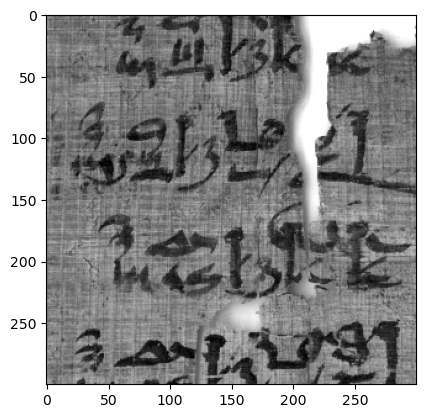

In [23]:
with torch.no_grad():
    for images, bb, cls in dataloader_test:
        inputs=images.to("cuda")
        bbox_outputs, clas_outputs=module(inputs)
        img=images[0].permute(1,2,0)
        plt.imshow(img)
        print(bbox_outputs[0], clas_outputs[0])
        break

In [26]:
# Ameliorate the model for when there is multi box

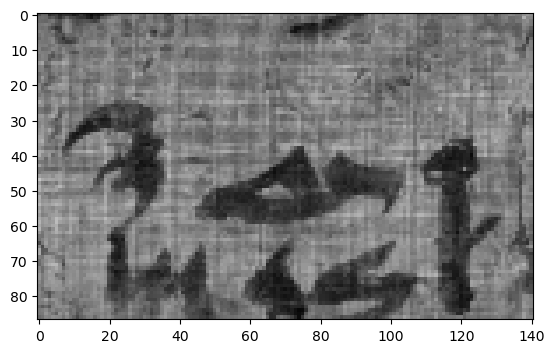

In [24]:
plt.imshow(img[137:224, 35:176])

### Problem: The bounding boxes on the dataset are not very precise. While it's not supposed to be this out of range

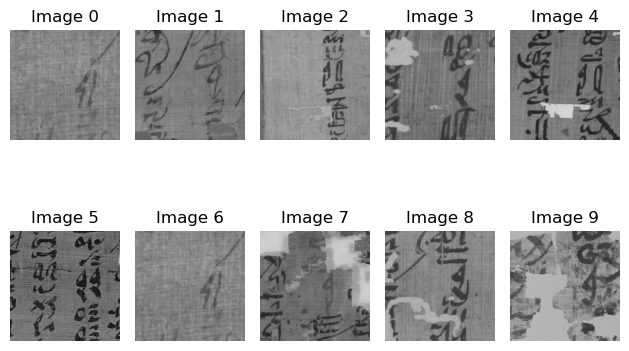

In [109]:
test=df.filter(pl.col('classes')=="1")
for i in range(0,10):
    bb=test['bb'][i]
    liste=bb.split(',')
    x1,y1,x2,y2=int(float(liste[0])), int(float(liste[1])), int(float(liste[2])), int(float(liste[3]))
    x1,y1,x2,y2
    img=io.read_image(os.path.join('/home/jovyan/my_work/Egypto/Images',test['filenames'][i]))
    img=img.permute(2,1,0)
    plt.subplot(2, 5, i+1)  # Arrange images in 2 rows and 5 columns
    plt.imshow(img[x1:x2,y1:y2])
    plt.axis('off')  # Hide axes
    plt.title(f"Image {i}")

plt.tight_layout()
plt.show()

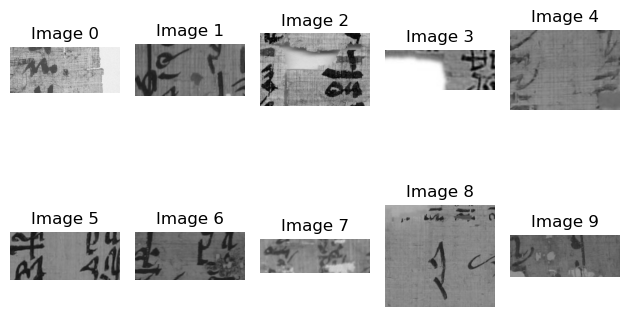

In [25]:
test=df.filter(pl.col('classes')=="1")
for i in range(0,10):
    bb=test['bb'][i]
    liste=bb.split(',')
    x1,y1,x2,y2=int(float(liste[0])), int(float(liste[1])), int(float(liste[2])), int(float(liste[3]))
    x1,y1,x2,y2
    img=io.read_image(os.path.join('/home/jovyan/my_work/Egypto/Images',test['filenames'][i]))
    img=img.permute(2,1,0)
    plt.subplot(2, 5, i+1)  # Arrange images in 2 rows and 5 columns
    plt.imshow(img[x1:x2,y1:y2])
    plt.axis('off')  # Hide axes
    plt.title(f"Image {i}")

plt.tight_layout()
plt.show()

In [41]:
os.getcwd()

'/home/jovyan/my_work/Egypto'

In [35]:
df.columns

['filenames', 'classes', 'bb']